In [3]:
import random
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import model
from model import weights_init
from myfolder import ImageFolder
from PIL import Image
import numpy as np
import scipy.io as sio
import csv
data_path = './dataset/leaves'

#convert array to unit8 (ot display the image)
def arr2unit8(arr):
    #arr m*n
#     img_numpy = input.data[0,:,:,:].cpu().numpy()[0,:,:] variable
    res = np.zeros((arr.shape[0],arr.shape[1]),dtype=np.uint8)
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if arr[i][j] > 0.5:
                res[i][j] = 255
    return res
        
#save results
class leaf_save:
    def __init__(self, classes, filename='sample_submission.csv'):
        first_row = ['id']
        first_row.extend(classes)
        self.csvfile = file(filename, 'wb')
        self.csv_writer = csv.writer(self.csvfile)
        self.csv_writer.writerow(first_row)
    
    def write_data(self, result):
        self.csv_writer.writerows(result)
        
    def close(self):
        self.csvfile.close()
        
    


if __name__ == "__main__":
    #train or test
    phase = 'test'
    #batch size
    nb = 512
    is_cuda = True
    random.seed(random.randint(1,10000))
    torch.manual_seed(random.randint(1,10000))
    pretrain_model = 'models/epoch_99.pth'
#     pretrain_model = ''
    #use cudnn
    cudnn.benchmark = True
    
    #Normalized to (0,1)
    trainset = ImageFolder(root=data_path+'/train', \
            transform=transforms.Compose([\
            transforms.ToTensor(),
            transforms.Normalize((0., 0., 0.),(1., 1., 1.))
            ]))
    train_loader = torch.utils.data.DataLoader(trainset, batch_size = nb,\
            shuffle=True, num_workers = 2)
    
    testset = ImageFolder(root=data_path+'/test', \
            transform=transforms.Compose([\
            transforms.ToTensor(),
            transforms.Normalize((0., 0., 0.),(1., 1., 1.))
            ]))
    test_loader = torch.utils.data.DataLoader(testset, batch_size = 1,\
            shuffle=False, num_workers = 2)

    # network
    net = model.leafnet(1)
    net.apply(weights_init)
    if pretrain_model != '':
        print 'loading pretrained model'
        net.load_state_dict(torch.load(pretrain_model))
    
    

    criterion = nn.CrossEntropyLoss()
    input = torch.FloatTensor(nb, 1, 96, 96)
    label = torch.LongTensor(nb)
    input_att = torch.FloatTensor(nb, 192)
    if is_cuda: 
        net.cuda()
        criterion.cuda()
        input = input.cuda()
        label = label.cuda()
        input_att = input_att.cuda()

    input = Variable(input)
    label = Variable(label)
    input_att = Variable(input_att)
#     optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.99)
#     optimizer = optim.RMSprop(net.parameters(), lr = 0.01, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=0.005, betas = (.5, 0.99))
    
    ## train
    if phase == 'train':
        for epoch in range(100):
            for i, (imgs, atts, labels) in enumerate(train_loader, 0):

                nb = labels.size(0)
                net.zero_grad()
                input.data.resize_(imgs.size()).copy_(imgs)
                label.data.resize_(nb).copy_(labels)
                input_att.data.resize_(atts.view(-1, 192).size()).copy_(atts.view(-1, 192))
                output = net(input, input_att, nb)
                loss = criterion(output, label)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                print 'Epoch: %d, ite:%d, loss is %f'%(epoch, i, loss.data[0])
            if epoch % 99 == 0:
                torch.save(net.state_dict(), 'models/epoch_%d.pth'%(epoch))
    else:
        submission = leaf_save(trainset.classes)
        imgs_test = []
        imgs_class = []
        results = []
        imgs_name = testset.imgs
        for i, (imgs, atts, _) in enumerate(test_loader, 0):
            result_i = []
            input.data.resize_(imgs.size()).copy_(imgs)
            
            origin_im = arr2unit8(input.data[0,:,:,:].cpu().numpy()[0,:,:])
            origin_im = Image.fromarray(origin_im)
            
            input_att.data.resize_(atts.view(-1, 192).size()).copy_(atts.view(-1, 192))
            output = net(input, input_att, 1).data.cpu().numpy()
            max_idx = np.where(output.reshape(99,1)== max(output.reshape(99,1)))[0][0]
            pred_class = trainset.classes[max_idx]
            
            img_name = imgs_name[i][0].split('/')[-1]
            idx = str(int(img_name[0:img_name.find('.')]))
            
            ### write to csv
            result_i.append(idx)
            for op in output.reshape(99,):
                result_i.append('%.6f'%op)
            results.append(tuple(result_i))
            ###visualization
            imgs_test.append(origin_im)
            imgs_class.append(pred_class)
            
        submission.write_data(results)
        submission.close()
        
            
            
    
    


loading pretrained model


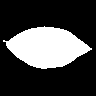

In [5]:
imgs_test[4]

In [6]:
imgs_class[4]

'Magnolia_Salicifolia'